# Stochastic modelling of COVID19 dataset
## Initial setup

In [28]:
library(tidyr)
library(tidyverse)
library(deSolve)
library(bbmle)
options(repr.plot.width = 8, repr.plot.height =4.5)
dev.new(width=8, height=2.5)


## Base Model: SIR
Now to warm up, we want to use the standard SIR model with no population dynamics:

$\frac{dS}{dt} = -\beta{S}{I}$

$\frac{dI}{dt} = \beta{S}{I} - \gamma{I}$

$\frac{dS}{dt} = \gamma{I}$

Creating this model in R:

In [29]:
SIR <- function(time, variables, parameters) {
  with(as.list(c(variables, parameters)), {
    dS <- -beta * I * S
    dI <- beta * I * S - gamma * I
    dR <-  gamma * I
    return(list(c(dS, dI, dR)))
  })
}

We then create a function to return an approximate value for our model given all parameters. We can make this return our infectious curve without the first point for fitting, and then the full model for displaying a fit that we like.

In [30]:
model <- function (gamma, beta, times, initial_data, fullData=FALSE) {
    out <- ode(func=SIR, y=initial_data,
               times=times,parms=c(gamma=gamma,beta=beta))
    if(fullData){
        return(out)
    }
    return(out[-1,3])
}

## Dataset: Flu in Boarding School
We have the classic dataset from a flu outbreak in a boarding school. Obtained from https://rdrr.io/cran/outbreaks/man/influenza_england_1978_school.html

In [31]:
df <- data.frame(read.csv('BoardingSchoolFlu.csv', header=TRUE))
N = 763
I0 = df$cases[1]
initial_conditions <- c(S=N-I0, I=I0, R=0)
initial_conditions

S   I   R 
760   3   0

And the graphing our cases over time:

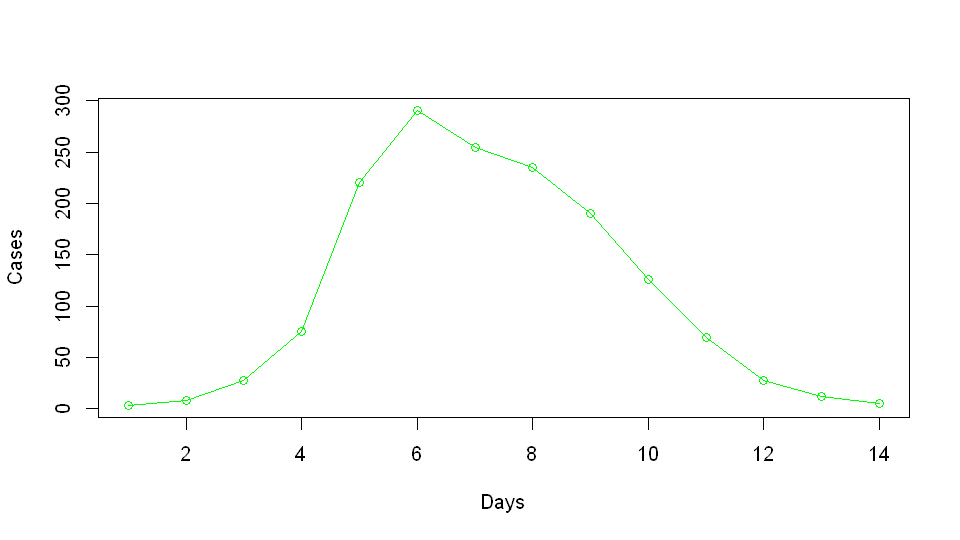

In [32]:
plot(df$days, df$cases, xlab='Days', ylab='Cases', col='green')
lines(df$days, df$cases,col='green')

Some code to make graphing a bit quicker:

In [81]:
compare_model <- function(model, title){
    model <- data.frame(model)
    plot(df$days, df$cases, xlab='Days', ylab='Cases', col='green', lwd=2, pch=20)
    legend(1, 250, legend=c("Predicted", "Actual"),
           col=c("red", "green"), lty=1:1, y.intersp=2)
    lines(loess(df$cases ~ df$days),col='green', lwd=2)
    
    lines(loess(model$I~model$time), col='red', lwd=2)
    points(model$time, model$I, col='red', pch=20)
    title(title)
}

## Parameter Estimation: MLE's using Normal Distribution 
We now want to create a maximum likelihood estimator of our model, with the aim of numerically maximising this to find estimates for our model's parameters.
We first assume each observation is normally distributed, with constant variance $\sigma^2$:

$Y_t \sim N(I_t, \sigma^2)$.
We want a function that will give a log likelihood of our dataset. To do this generally, assume that each datapoint has the same distribution with parameters $\underline{\theta}$, so each datapoint has the PDF: $f(y |  \underline{\theta})$.
Then our likelihood function is: 
$L =\displaystyle \prod_{t=0}^{n-1}f(Y_t | \underline{\theta}_t)$,
and our log likelihood function is:
$L =\displaystyle \sum_{t=0}^{n-1}\log{(f(Y_t | \underline{\theta}_t))}$ 

At first this is a normal distribution so the likelihood function can be implemented. We return the minus log likelihood as this is what our package uses to estimate parameters.




In [130]:
likelihood <- function(gamma, beta,sigma){
    beta <- exp(beta)
    gamma <- exp(gamma)
    sigma <- exp(sigma)
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_data=initial_conditions)
    -sum(dnorm(x=df$cases[-1],mean=model_data, sd=sigma, log=TRUE))
}

Our aim is then to maximimise our log-likelihood function, which we can do using the `bblme` package.

In [131]:
initial_params <- c(gamma=0.5, beta=0.05, sigma=1)
results <- mle2(minuslogl = likelihood, start = lapply(initial_params, log),method = "Nelder-Mead")
parameters <- exp(coef(results))
parameters

gamma         beta        sigma 
 0.450626519  0.002215839 17.473993358

Now we can compare our estimate against our data

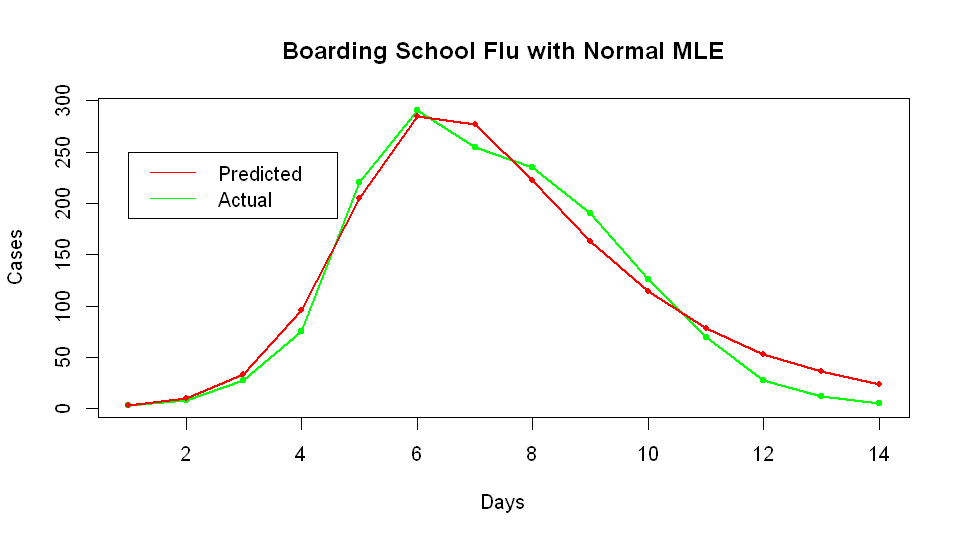

In [83]:
normal_model <- model(gamma=as.double(parameters['gamma']), beta=as.double(parameters['beta']), times=df$days, initial_data=initial_conditions, fullData=TRUE)
compare_model(normal_model,'Boarding School Flu with Normal MLE' )

## Parameter Estimation: MLE's using Poisson Distribution
We can try a Poisson distribution instead: $Y_t \sim Po(I_t)$. Our log-likelihood function is then:

In [84]:
likelihood_po <- function(gamma, beta){
    beta <- exp(beta)
    gamma <- exp(gamma)
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_data=initial_conditions)
    -sum(dpois(x = df$cases[-1], lambda = model_data[-1], log = TRUE))
}

We can then repeat our estimation:

In [108]:
po_initial_params <- c(gamma=0.5, beta=0.005)
po_results <- mle2(minuslogl = likelihood_po, start = lapply(po_initial_params, log),method = "Nelder-Mead")
po_parameters <- exp(coef(po_results))
po_parameters

gamma        beta 
0.454269982 0.001893685

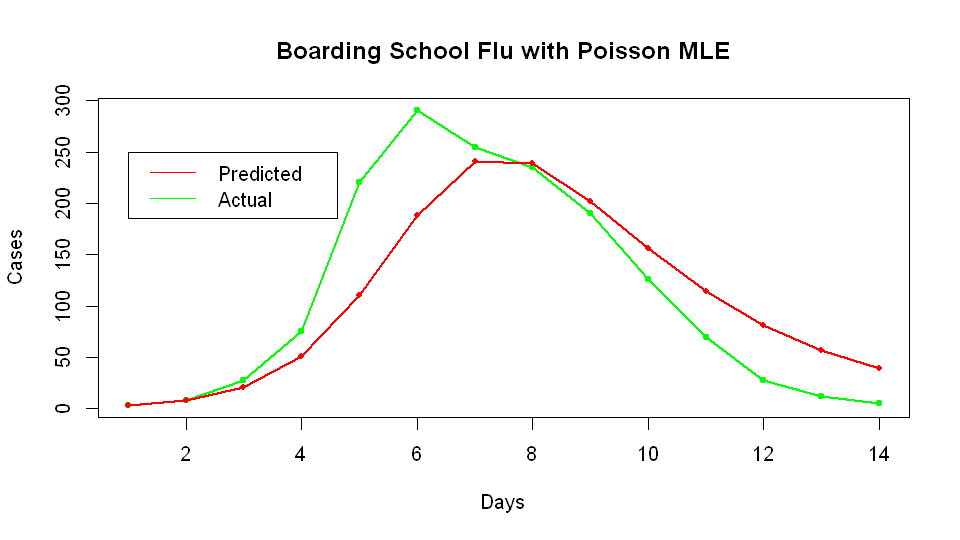

In [109]:
po_model <- model(gamma=as.double(po_parameters['gamma']), beta=as.double(po_parameters['beta']),
                  times=df$days, initial_data=initial_conditions, fullData=TRUE)

compare_model(po_model, 'Boarding School Flu with Poisson MLE')

## Model Comparison
Now we seek to compare the two variations of our model. Both models work by seeking to maximise the log-likelihood given that our data has a certain distribution. Hence from this perspective, the more "better" model would be the one with a larger log-likelihood.

Our Normal log-likelihood value:

In [87]:
-logLik(results)

'log Lik.' 55.5634 (df=3)

Our Poisson log-likelihood value:

In [88]:
-logLik(po_results)

'log Lik.' 103.0863 (df=2)

So from this perspective the Poisson model is an improvement of the Normal model. 
## Fitting $I_0$
We could also try and fit $I_0$, by first applying the bound $1 \leq I_0 \leq I(0)$. Then we can remove it from our data fields and add it to our parameters to be fitted instead. Using our Normal likelihood:

In [126]:
likelihood_i <- function(gamma, beta, I, sigma){
    beta <- exp(beta)
    gamma <- exp(gamma)
    I <- exp(I)
    sigma<-exp(sigma)
    initial <- c(S=as.double(initial_conditions['S']), I=I, R=as.double(initial_conditions['R']))
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_data=initial)
    -sum(dnorm(x=df$cases[-1],mean=model_data, sd=sigma, log=TRUE))
}

gamma         beta            I        sigma 
 0.457421207  0.002310999  2.258970874 16.968556503

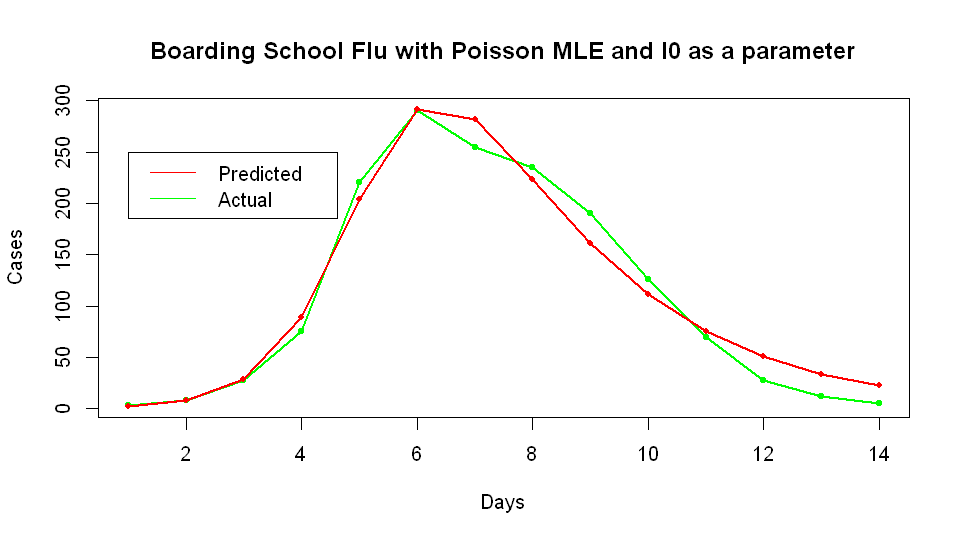

In [129]:
i_initial_params <- c(gamma=0.5, beta=0.005, I=3, sigma=10)
i_results <- mle2(minuslogl = likelihood_i, start = lapply(i_initial_params, log), method = "Nelder-Mead")
i_parameters <- exp(coef(i_results))
i_parameters
i_model <- model(gamma=as.double(i_parameters['gamma']), beta=as.double(i_parameters['beta']),
                  times=df$days, initial_data=c(S=as.double(initial_conditions['S']), I=as.double(i_parameters['I']), R=as.double(initial_conditions['R'])), fullData=TRUE)

compare_model(i_model, 'Boarding School Flu with Poisson MLE and I0 as a parameter')